<a href="https://colab.research.google.com/github/Bengisunz/Data-Analytics-and-Machine-Learning-Projects/blob/master/GoogleAnalyticsCaseStudy_BengisuOniz_With_Codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Bengisu Öniz

11.11.2019


##About the Data & Case

The table is 
bigquery-public-data:google_analytics_sample.ga_sessions_20170801


**Questions**

These are the questions l am looking answers.


1. How many sessions do users create on average within the day?
2. What is the conversion rate per traffic medium?
3. How many hits do users generate per visit on average on the platform? 
4. What is the top 5 country in terms of the amount of traffic (visits)
5. How much time passes until users click on a product (hits.eventInfo.eventAction = 'Product Click')?
6. Visualise the visits per hour of the day.
7. What is the peak hour for visits with transactions? Annotate it on the plot of Task 6.
8. Plot a histogram of time spent on the platform.
9. Do you see any correlation between time spent on the platform and the total revenue? Try to explain with a plot and comment on it.
10. Try to visualise the pair distribution (2D) of the time spent on the platform and total number of hits, for each visit. Compare and comment on such distribution for top two countries with most traffic.






l want to check the main metrics of the web page at first.


| date  |visits   |pageviews  |transactions |revenue
|:--:|:--:|:--:|:--:|:--:|
| 20170801|	2556	|10939|	45	|8304.94  |

                                                          Average transaction per user is 2.12


                                                          The number of transactions per browser

|device_browser|total_transactions|
|:--:|:--:|
|Chrome|41|
 |Safari|3|
 |Firefox|1|
 |Internet Explorer|null|
|UC Browser|null|



## Downloading Neccasary Python Libraries

In [0]:
#@title
# Google Drive  ortamına bağlanma
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#@title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from matplotlib.pyplot import figure
import plotly.graph_objects as go
from datetime import datetime
from scipy import stats

%matplotlib inline

plt.style.use("seaborn-notebook")

# 1. How many sessions do users create on average within the day? 



Legacy SQL

```sql
select avg(sessions) as total_sessions from (
  select
    fullvisitorid,
    count(visitid) as sessions,
    from [bigquery-public-data:google_analytics_sample.ga_sessions_20170801]
    group each by fullvisitorid)
```


Legacy SQL

``` sql
SELECT
  fullVisitorId,
  SUM(totals.visits) as visits,
  SUM(totals.pageviews) as pageviews,
FROM
  [bigquery-public-data.google_analytics_sample.ga_sessions_20170801]
GROUP BY
  fullVisitorId
HAVING visits>0 and pageviews>0

```

``` sql
SELECT
( SUM(total_pagesviews_per_user) / COUNT(users) ) AS avg_pageviews_per_user
FROM
(SELECT
  fullVisitorId AS users,
  SUM(totals.pageviews) AS total_pagesviews_per_user
FROM
  [bigquery-public-data:google_analytics_sample.ga_sessions_20170801]
WHERE
  totals.transactions >=1
GROUP BY
  users)
  
```


| Row  |AVG_Sessions   |
|:--:|:--:|
|  1 | 1.1146  |


Average sessions users create within the day is 1.12

In [0]:
#@title Other Main Statistics about Sessions and Pageviews

path = "/content/drive/My Drive/dh_data/sessions_pageviews.csv"
data = pd.read_csv(path)
data[["visits","pageviews"]].describe()

,visits,pageviews
count,2293.000000,2293.000000
mean,1.114697,4.770606
std,0.385624,9.095320
min,1.000000,1.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,1.000000,4.000000
max,4.000000,155.000000



>Average page views visitors see within the day is 4.8 (Query 1.1). 
Furthermore, average page view within a session per visiters who make a purchase is  30.4 (Query 1.2) and visitors who did not make a purchase  is 4.3 . Hence, visitors who tends to purchase check more products on the platfrom.  To improve their purchasing experience it would be nice to create product comparison tools or recommendation system.  

  
# 2. What is the conversion rate per traffic medium? 

Legacy SQL

``` sql

SELECT
  (total_transactions_per_user / visit_count ) AS conversion,
  trafficSource.medium
FROM (
  SELECT
    trafficSource.medium,
    SUM(totals.visits) AS visit_count,
    SUM(totals.transactions) AS total_transactions_per_user
  FROM
    [bigquery-public-data.google_analytics_sample.ga_sessions_20170801]
  WHERE
    totals.visits> 0
  GROUP BY
    trafficSource.medium)
    
```



| trafficSource_medium  |  Conversion_Rate |
|--:|---|
|   	(none)| 0.020  |
| referral 	|  0.003   |
|  organic | 	 none  |
| cpm	|   none |   
| affiliate	| none     |



Direct traffics is the one of the highest conversion rate within all traffic medium sources.

#3. How many hits do users generate per visit on average on the platform?



Legacy SQL

```sql
SELECT
( SUM(total_hits_per_user) / SUM(total_visits_per_user) ) AS
avg_hits_by_user_per_visit
FROM (SELECT
  fullVisitorId,
  SUM(totals.visits) AS total_visits_per_user,
  SUM(totals.hits) AS total_hits_per_user
FROM
  [bigquery-public-data.google_analytics_sample.ga_sessions_20170801]
WHERE
  totals.visits > 0
  AND totals.hits >= 1
GROUP BY
  fullVisitorId)

```


Legacy SQL

```sql

SELECT
  AVG(ratio_per_user)
FROM (
  SELECT
    SUM(total_hits_per_user/total_visits_per_user) OVER (PARTITION BY fullVisitorId) AS ratio_per_user
  FROM (
    SELECT
      fullVisitorId,
      SUM(totals.visits) AS total_visits_per_user,
      SUM(totals.hits) AS total_hits_per_user
    FROM
      [bigquery-public-data.google_analytics_sample.ga_sessions_20170801]
    WHERE
      totals.visits > 0
      AND totals.hits >= 1
    GROUP BY
      fullVisitorId))
      
```


The average number of hits by users is found as	4.85.

# 4. What is the top 5 country in terms of the amount of traffic (visits)? 


Legacy SQL

``` sql
SELECT
  geoNetwork.country AS Country,
  COUNT(visitId) AS Visits
FROM
  [bigquery-public-data.google_analytics_sample.ga_sessions_20170801]
WHERE
  totals.visits = 1
GROUP BY
  Country
ORDER BY
  Visits DESC
LIMIT
  5

```



| Country  | Visits  |
|--:|---|
|   United States|  	1287 |
| India	|  155    |
|  United Kingdom | 	142 |   |
| Germany	|  91  |   |
| Canada	|  85    |


United States has the highest traffic with 1287 visits in a day.

# 5. How much time passes until users click on a product (hits.eventInfo.eventAction = 'Product Click')? 

Legacy SQL


``` sql
SELECT
  fullVisitorId,
  visitid,
  visitStartTime,
  hits.time,
  TIMESTAMP(INTEGER(visitStartTime*1000000)) AS start_time12,
  TIMESTAMP(INTEGER(visitStartTime*1000000 + hits.time*1000)) AS hits_time12
FROM
  [bigquery-public-data.google_analytics_sample.ga_sessions_20170801]
WHERE
  hits.eventInfo.eventAction = 'Product Click'

```



In [0]:
#@title About the data

path = "/content/drive/My Drive/dh_data/q5_data.csv"
data = pd.read_csv(path)
data.head()


,fullVisitorId,visitid,visitStartTime,hits_time,start_time12,hits_time12
0,138058039294367332,1501628807,1501628807,0,2017-08-01 23:06:47 UTC,2017-08-01 23:06:47 UTC
1,7605971862730185115,1501580187,1501580187,37012,2017-08-01 09:36:27 UTC,2017-08-01 09:37:04.012 UTC
2,4107476716931948379,1501574999,1501574999,36298,2017-08-01 08:09:59 UTC,2017-08-01 08:10:35.298 UTC
3,1792126295682358590,1501577127,1501577127,36749,2017-08-01 08:45:27 UTC,2017-08-01 08:46:03.749 UTC
4,1281234459613429134,1501586692,1501586692,25834,2017-08-01 11:24:52 UTC,2017-08-01 11:25:17.834 UTC


In [0]:
#@title Verifying the time differences 

list_hits=[]
for i in range(len(data["hits_time12"])):
  time = data["hits_time12"].loc[i][:-4]
  list_hits.append(time)


list_hits_date=[]
for i in range(len(list_hits)):
  if len(list_hits[i]) == 19: #without micro seconds 
    time_short = datetime.strptime(list_hits[i], '%Y-%m-%d %H:%M:%S')
    list_hits_date.append(time_short)
  else:
    time = datetime.strptime(list_hits[i], '%Y-%m-%d %H:%M:%S.%f')
    list_hits_date.append(time)  


data["hits_time_format"] = list_hits_date   

list_startime=[]
for i in range(len(data["start_time12"])):
  time = data["start_time12"].loc[i][:-4]
  list_startime.append(time)


list_starttime_date=[]
for i in range(len(list_startime)):
  if len(list_startime[i]) == 19: #without micro seconds 
    time_short = datetime.strptime(list_startime[i], '%Y-%m-%d %H:%M:%S')
    list_starttime_date.append(time_short)
  else:
    time = datetime.strptime(list_startime[i], '%Y-%m-%d %H:%M:%S.%f')
    list_starttime_date.append(time)

data["visits_time_format"] = list_starttime_date 

differences=[]
for i in range(len(list_starttime_date)):
    diff= (list_hits_date[i] - list_starttime_date[i]).total_seconds()
    differences.append(diff)

data["differences"] = differences     

mean_diff_per_visitor = data.groupby("fullVisitorId").mean()[["differences"]]
mean_diff_per_visitor.sample(10)

,differences
fullVisitorId,
6687958275730704367,241.149000
11577526465501235,595.112500
7550413639587874054,925.239500
7720463169914643064,142.899667
5926242413751959519,41.174500
3289637780548369455,947.466500
1633146081774573328,488.972000
34988253365419131,108.393000
7605971862730185115,37.012000


In [0]:
#@title Basic Statistics of the time passes until users click on a product
data["differences"].describe()

count     411.000000
mean      489.200579
std       717.511784
min         0.000000
25%        85.559000
50%       221.681000
75%       617.646500
max      5376.459000
Name: differences, dtype: float64



> Average time passes for users to click on a product after they start to be active on the site is 489 seconds. % 75 of the visitors click on a product after 618 seconds after they visit to platfrom.






In [0]:
#@title Histogram of Time Passes until Users Click on a Product

fig = px.histogram(data, x="differences", nbins=100)
fig.update_traces(marker=dict(color='rgba(238,118,0,.9)'))

fig.show()

Did those visitors whose time is higher than 2000 face a difficulty to find the product they were looking for?

# 6. Visualise the visits per hour of the day. 
#  7. What is the peak hour for visits with transactions? Annotate it on the plot of Task 6. 


Legacy SQL
``` sql
SELECT  HOUR(SEC_TO_TIMESTAMP(visitStartTime)) AS sessionHour,
       COUNT(totals.visits) AS sessionCount,
       COUNT(totals.transactions) AS transactions
FROM [bigquery-public-data.google_analytics_sample.ga_sessions_20170801]
GROUP BY sessionHour
ORDER BY sessionHour, sessionCount DESC
```

In [0]:
#@title About the data

path = "/content/drive/My Drive/dh_data/q_7_6.csv"
veri = pd.read_csv(path)
veri.head()

,sessionHour,sessionCount,transactions
0,0,87,0
1,1,102,0
2,2,84,3
3,3,99,0
4,4,79,2


In [0]:
#@title Transforming the data for plotting

df_melt = veri.melt(id_vars='sessionHour', value_vars=['sessionCount', 'transactions'])
df_melt.head()

,sessionHour,variable,value
0,0,sessionCount,87
1,1,sessionCount,102
2,2,sessionCount,84
3,3,sessionCount,99
4,4,sessionCount,79


In [0]:
#@title Number of Visits and Transactions per Hour of the Day
px.line(df_melt, x='sessionHour' , y='value' , color='variable')

> The peak time of the visits is 8 pm.

> The peak time of the visits is 2 pm. The number of visits at 2 pm is also higher than the average visits. This indicates that visitors check the products at evening times, buy them after lunchtime.

> It would be better not to do maintenance & background tasks that are not related to sales processes at peak times to make the platform faster. Perhaps if the platform is cloud-based and available to increase the number of servers fast then the number of servers can be increased at peak times.

### 7.1 Bounce Rate per Hour of the Day 

In [0]:
#@title
path = "/content/drive/My Drive/dh_data/bouncerate.csv"
data_bouncerate = pd.read_csv(path)
data_bouncerate["bounceRate"].describe()

count    24.000000
mean      0.496609
std       0.101165
min       0.310345
25%       0.445822
50%       0.477004
75%       0.542291
max       0.731343
Name: bounceRate, dtype: float64

In [0]:
#@title
data_bouncerate = data_bouncerate.sort_values(by="sessionHour")

In [0]:
#@title Bounce Rate per Hour of the Day
fig71 = px.line(data_bouncerate,x="sessionHour", y="bounceRate", labels={'x':'Session Hour', 'y':'Bounce Rate'})
fig71.update_traces(line=dict(color='rgba(77,0,13,.9)'))
fig71.show()


The highest bounce rate occurs at 10 am. This chart is not surprising after seeing the peak times of the visits.

# 8. Plot a histogram of time spent on the platform. 


Standard SQL

```sql

SELECT
  COUNT(fullVisitorId) AS num_visitors,
  timeOnSite
FROM (
  SELECT
    totals.timeOnSite as timeOnSite,
    fullVisitorId
  FROM
    `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
  WHERE
    totals.timeOnSite IS NOT NULL)
GROUP BY
  timeOnSite

```

In [0]:
#@title Main Statistics about the Time Spent on the Platform (in Seconds)

path = "/content/drive/My Drive/dh_data/notcounted_8.csv"
data = pd.read_csv(path)

data["timeOnSite"].describe()

count    1310.000000
mean      325.051908
std       592.411724
min         1.000000
25%        32.000000
50%        96.500000
75%       336.750000
max      5455.000000
Name: timeOnSite, dtype: float64

In [0]:
#@title Histogram of Time Spent on the Platform

fig8 = px.histogram(data, x="timeOnSite", nbins=150)
fig8.update_traces(marker=dict(color='rgba(204, 44, 36, .9)'))

fig8.show()

Most of the visitors spend time on the platform between 0- 99 seconds.
It is seen that there are outliers who spend time on the platform more than 2000 seconds.

# 9. Do you see any correlation between time spent on the platform and the total revenue? Try to explain with a plot and comment on it.


Standard SQL

``` sql
SELECT
  totals.timeOnSite AS timeOnSite,
  totals.totalTransactionRevenue,
  fullVisitorId
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
WHERE
  totals.timeOnSite IS NOT NULL
```

In [0]:
#@title About the Data

path = "/content/drive/My Drive/dh_data/q_9.csv"
data_q9 = pd.read_csv(path)
data_q9.head()

,timeOnSite,totalTransactionRevenue,fullVisitorId
0,21,NaN,9563201247433687898
1,22,NaN,446881336866901267
2,14,NaN,7639981567880780476
3,60,NaN,1323143631015435941
4,6,NaN,5170381678885002061


                         timeOnSite  totalTransactionRevenue
timeOnSite                 1.000000                 0.049149
totalTransactionRevenue    0.049149                 1.000000


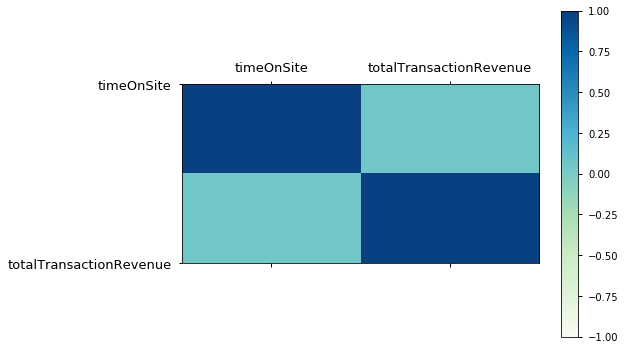

In [0]:
#@title

column_names=["timeOnSite","totalTransactionRevenue"]
data_for_corr= data_q9[column_names]

def CheckingCorrelations(df,colorstyle):

    column_names=df.columns 
    num = len(column_names)
    correlations = df[column_names].corr()
    print(correlations)

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1,cmap=colorstyle)  
    fig.colorbar(cax)
    ticks = np.arange(0, num, 1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(column_names)
    ax.set_yticklabels(column_names)
    ax.tick_params(labelsize=13)
    plt.show()

CheckingCorrelations(data_for_corr,'GnBu')

> In contrast to the common expectation, there is no relation between time spent on the platform and the total revenue. Regarding this, it would be good to make the purchasing process faster, help users to find the products they are looking for or help them to find out the products they need or want.



#10. Try to visualise the pair distribution (2D) of the time spent on the platform and total number of hits, for each visit. Compare and comment on such distribution for top two countries with most traffic. 


Standard SQL

``` sql
SELECT
  totals.hits,
  totals.timeonsite,
  visitid
FROM
  `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
WHERE
  totals.timeonsite IS NOT NULL
  AND geoNetwork.country='United States'
```

**USA**


---






In [0]:
#@title About the Data

path = "/content/drive/My Drive/dh_data/q10_US.csv"
data_q10_us = pd.read_csv(path)
data_q10_us.describe()

,hits,timeonsite,visitid
count,820.000000,820.000000,8.200000e+02
mean,10.512195,368.608537,1.501620e+09
std,15.591664,650.388708,1.851463e+04
min,2.000000,1.000000,1.501570e+09
25%,3.000000,31.000000,1.501606e+09
50%,5.000000,108.000000,1.501620e+09
75%,12.000000,404.000000,1.501634e+09
max,193.000000,5455.000000,1.501657e+09


In [0]:
#@title Time Spent on the Platform vs Total Number of Hits in United States

fig = px.scatter(data_q10_us, x="timeonsite", y="hits")
fig.update_traces(marker=dict(size=5,color='rgba(49, 17, 65, .9)'))

fig.show()

> It is seen that time spent on the platform and the total number of hits share the same trend. When the total time spent on the platform increases the number of hits increases but the number of the hits increase slower compared to the total time spent on the site.



                hits  timeonsite
hits        1.000000    0.674747
timeonsite  0.674747    1.000000


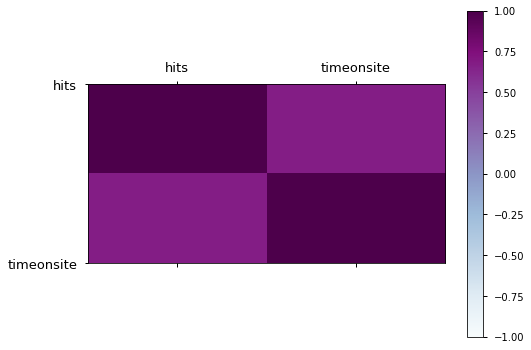

In [0]:
#@title  Correlation of Time Spent on the Platform and Total Number of Hits in United States

data_q10_us_corr=data_q10_us[["hits", "timeonsite"]]
CheckingCorrelations(data_q10_us_corr,'BuPu')

> It is seen that there is a positive correlation between the time spent on the platform and the total number of hits, for each visit in the United States. The more user exists on the platform their interaction with the platform increases user interaction.  For that reason, it is better to check the correlation between these features.

**India**


---





In [0]:
#@title About the Data

path = "/content/drive/My Drive/dh_data/q10_India.csv"
data_q10_india = pd.read_csv(path)
data_q10_india.describe()

,hits,timeonsite,visitid
count,63.000000,63.000000,6.300000e+01
mean,6.174603,260.476190,1.501603e+09
std,5.490578,685.380701,2.404722e+04
min,2.000000,6.000000,1.501571e+09
25%,2.000000,40.500000,1.501583e+09
50%,4.000000,93.000000,1.501600e+09
75%,8.000000,265.000000,1.501615e+09
max,26.000000,5362.000000,1.501656e+09


In [0]:
#@title Time spent on the platform vs Total Number of Hits in India

fig = px.scatter(data_q10_india, x="timeonsite", y="hits")
fig.update_traces(marker=dict(size=8,color='rgba(17, 65, 49, .9)'))
fig.show()

>  The graph above indicates that there is not a certain relation between time spent on the platform and the total number of hits.

                hits  timeonsite
hits        1.000000    0.243126
timeonsite  0.243126    1.000000


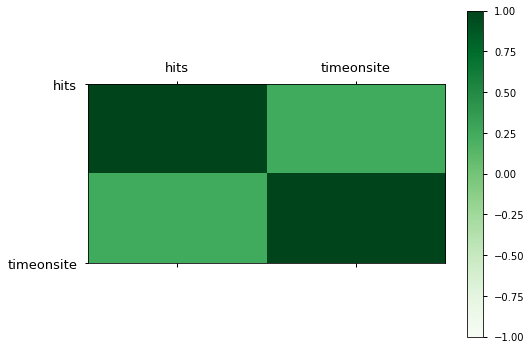

In [0]:
#@title  Correlation of Time spent on the platform and Total Number of Hits in India

data_q10_india_corr=data_q10_india[["hits", "timeonsite"]]
CheckingCorrelations(data_q10_india_corr,'Greens')

>It is seen that there is  a low correlation between the time spent on the platform and total number of hits, for each visit in India.
This is in contrast to the behaviour of visitors' interaction according to time spent on the platfom in the United States. Visitors from India.

In [0]:
#@title #Independent T-Test for the Features

hits_india_array=data_q10_india["hits"].values
hits_us_array=data_q10_us["hits"].values

time_india_array=data_q10_india["timeonsite"].values
time_us_array=data_q10_us["timeonsite"].values

print("Independent t test for hits", stats.ttest_ind(hits_india_array, hits_us_array, equal_var = False))
print("Independent t test for timeonsite", stats.ttest_ind(time_india_array, time_us_array, equal_var = False))

Independent t test for hits Ttest_indResult(statistic=-4.927242261683068, pvalue=2.0864422117164175e-06)
Independent t test for timeonsite Ttest_indResult(statistic=-1.2110656826126858, pvalue=0.22989444434321057)


> We can conclude that there is a significant difference between means of the hits in the countries. (2.09e-06 < 0.05)  
Additionally, there is no difference between means of the time on the site in the countries. (0.23 > 0.05)

> To review, visitors in India spend more time on the pages than visitors from the United States. Perhaps this situation is related to the content of the pages for visitors from India. The internet may be slow in India. There may be other hypotheses to be tested.

**Checking Page Loading Time for the Countries**

| Country  | Average Page Load Time in millisecond |
|:--:|:---:|
|   United States|  	9532 |
| India	|  3632.7    |




l think it would be good to compare the page load time in countries. Page load time is not longer in India than the United States. There might be another reasons of the previous finding. 


# Opinions about the data structure
 
Firstly, It is good to understand how BigQuery works.(A semi-structured data format and distributed file system). Examining structs/ records, unnesting arrays were new for me. People who are new on BigQuery Structs should be careful while analyzing at first. After being familiar with array types, it will not be a problem to work on the data. In this data structure, we do not have to deal with so many tables and joins. They are all in one which makes computation faster. 

This data type is at session-level. Individual page views are nested. When we want to create a custom event on page view level, it would be hard to specify our own schema.

As well as, we can create intermediate tables and then retrieve and analyze the data with other tools like Python. We do not need to write a query every time. For example, we can create an intermediate table for conversion metrics.

Conversely, it is not available to see the full table ( like SELECT *FROM [table] ). Sometimes we need to check the table with eyes at first. This is just a small issue, of course, there is a preview of the data. Another essential point is that nested columns have a [depth limit](https://cloud.google.com/bigquery/docs/nested-repeated) while analyzing.

Furthermore, we cannot add any calculated column to the main table. We depend on Google’s column names only. Some of the column names are also out of use.
BigQuery can be a little bit risky for newbies because while practising there, they might not construct their queries properly. This may cost. 
On the other hand, it is good to do complex aggregation function like STDDEV_POP().

To sum up, there are some challenges in querying because of the distributed data structures or cost risks. I think these costs are affordable when we think BigQuery’s performance benefit and scalability. 
 

# References


*  BigQuery documentation: https://cloud.google.com/bigquery/docs/
https://www.lunametrics.com/blog/2016/02/11/querying-google-analytics-data-in-bigquery/

*  https://support.google.com/analytics/answer/7586738
*  https://support.google.com/analytics/answer/4419694
* https://medium.com/firebase-developers/using-the-unnest-function-in-bigquery-to-analyze-event-parameters-in-analytics-fb828f890b42


# Other BigQuery Codes

**Intro**

Legacy SQL

```sql

SELECT
  date,
  SUM(totals.visits) AS visits,
  SUM(totals.pageviews) AS pageviews,
  SUM(totals.transactions) AS transactions,
  SUM(totals.transactionRevenue)/1000000 AS revenue
FROM
  [bigquery-public-data.google_analytics_sample.ga_sessions_20170801]
GROUP BY
  date
ORDER BY
  date ASC

```

**Intro 2: Average Total Transactions per User**

Legacy SQL

``` sql

SELECT
  (SUM (total_transactions_per_user) / COUNT(fullVisitorId) ) AS avg_total_transactions_per_user
FROM (
  SELECT
    fullVisitorId,
    SUM (totals.totalTransactionRevenue) AS total_transactions_per_user
  FROM
   [bigquery-public-data.google_analytics_sample.ga_sessions_20170801]
  WHERE
    totals.transactions IS NOT NULL
  GROUP BY
    fullVisitorId)


```



**Intro 3: Total Transactions per Device**

Legacy SQL

``` sql
SELECT device.browser AS device_browser,
            SUM(totals.transactions) as total_transactions
FROM [bigquery-public-data:google_analytics_sample.ga_sessions_20170801]
GROUP BY device_browser
ORDER BY total_transactions DESC
```



**Page Loading Time for Countries**

Legacy SQL

``` sql
SELECT
  geoNetwork.country AS Country,
  avg(hits.latencyTracking.pageLoadTime) as avg_pageLoadTime	
FROM
  [bigquery-public-data.google_analytics_sample.ga_sessions_20170801]
WHERE 
  hits.latencyTracking.pageLoadTime is not null
and
  geoNetwork.country in ('India','United States')
GROUP BY
  Country
```



## Datasets of the Bigquery Results

You can find the datasets from [this drive link](https://drive.google.com/drive/folders/1xBouVMbw1kdpu8eKhnuTQcCqH3C17rVI?usp=sharing)
